In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw 

import hypergraphx as hgx
from hypergraphx.filters import metadata_filters

from tqdm.notebook import tqdm

from tqdm.auto import tqdm
tqdm.pandas()

import sys
sys.path += ['../']

from src.plot_configs import w_inc_fullpage, h_inc, set_plot_configs
set_plot_configs()

from src.filters import get_svmis

FIG_FOLD = "../paper/figures/"
if not os.path.exists(FIG_FOLD):
    os.makedirs(FIG_FOLD)


In [2]:
def filter_by_cuisine(H, cuisine):

    H_filtered = H.copy()

    for edge, meta in H.get_edges(metadata=True).items():
        cuisines = meta["cuisine"].split(" - ")
        if cuisine not in cuisines:
            H_filtered.remove_edge(edge)

    # remove isolated nodes
    for node in H_filtered.isolated_nodes():
        H_filtered.remove_node(node)

    return H_filtered

In [3]:
def load_recipies():

    # small number of recipes in these cuisines
    CUISINES_EXCLUDE = ["misc_central_american", "misc_dutch", "misc_belgian"]

    recipes_df = pd.read_csv("../data/recipies/edgelist.csv", sep=";")

    # get ingredients
    all_ingredients_df = recipes_df[["ingredient", "category"]].drop_duplicates().reset_index(drop=True)

    # get all cuisines
    all_cuisines_list = recipes_df["cuisine"].unique().tolist()
    all_cuisines_list = [c for c in all_cuisines_list if c not in CUISINES_EXCLUDE]

    node2id = {}
    H = hgx.Hypergraph()
    for recipe_id, ingredients_df in recipes_df.groupby("id"):

        if len(ingredients_df) < 2:
            continue

        cuisine = ingredients_df["cuisine"].values[0]

        if cuisine in CUISINES_EXCLUDE:
            continue

        edge = set()
        for _, row in ingredients_df.iterrows():
            ingredient = row["ingredient"]
            category = row["category"]

            if ingredient not in node2id:
                node_id = len(node2id)
                node2id[ingredient] = node_id

                H.add_node(node_id, metadata={"name": ingredient, "category": category})
            else:
                node_id = node2id[ingredient]

            edge.add(node_id)

        edge = tuple(sorted(edge))

        if not H.check_edge(edge):
            edge_meta = {"recipe_id": str(recipe_id), "cuisine": cuisine}
            H.add_edge(edge, metadata=edge_meta)
        else:
            edge_meta = H.get_edge_metadata(edge)
            edge_meta["recipe_id"] += f" - {recipe_id}"
            #edge_meta["title"] += f" - {r_meta['title']}"
            edge_meta["cuisine"] += f" - {cuisine}" if cuisine not in edge_meta["cuisine"] else ""
            H.set_edge_metadata(edge, edge_meta)
            
    # add node id to all_ingredients_df
    all_ingredients_df["node_id"] = all_ingredients_df["ingredient"].map(node2id)

    return H, all_ingredients_df, all_cuisines_list

In [4]:
# load the dataset
H, ingredients_df, all_cuisines_list = load_recipies()
H.num_nodes(), H.num_edges()

(604, 43751)

In [5]:
ingredients_df.head()

,ingredient,category,node_id
0,capsicum,Vegetable,0
1,chili pepper,Vegetable,1
2,sunflower,Flower,2
3,buttermilk,Dairy,3
4,cumin,Spice,4


In [6]:
all_cuisines_list

['indian',
 'african',
 'chinese',
 'thai',
 'south_east_asia',
 'middle_east',
 'korean',
 'japanese',
 'australasian',
 'mexican',
 'caribbean',
 'south_american',
 'central_european',
 'greek',
 'french',
 'misc_portuguese',
 'italian',
 'british_isles',
 'scandinavian',
 'east_european',
 'spanish',
 'american',
 'canadian']

In [7]:
# remove hyperedges of size > 10
H_cut = H.copy()

for size in range(11, H_cut.max_size() + 1):
    for edge in H_cut.get_edges(size=size):
        H_cut.remove_edge(edge)

# remove isolated nodes
for node in H_cut.isolated_nodes():
    H_cut.remove_node(node)

print("Number of nodes after cutting: ", H_cut.num_nodes())
print("Number of hyperedges after cutting: ", H_cut.num_edges())
print("Number of recipes after cutting: ", sum(H_cut.get_weights()))

Number of nodes after cutting:  580
Number of hyperedges after cutting:  32291
Number of recipes after cutting:  32291


In [8]:
# extract SVMIS
svmis_file = "../results/recipes/svmis_recipes.parquet"

if not os.path.exists(svmis_file):
    print("Extracting SVMIS...")
    svmis_df = get_svmis(H_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
    svmis_df = pd.concat(svmis_df).reset_index(drop=True)

    # save file
    if not os.path.exists(os.path.dirname(svmis_file)):
        os.makedirs(os.path.dirname(svmis_file))
    svmis_df.to_parquet(svmis_file)

else:
    print("Loading SVMIS from file...")
    svmis_df = pd.read_parquet(svmis_file)

svmis_df.head()

Loading SVMIS from file...


,group,pvalue,fdr,size
0,"[2, 3, 4, 5, 7, 8, 10, 11, 13, 27]",3.847664e-14,False,10
1,"[1, 3, 4, 5, 7, 8, 13, 27, 42, 43]",3.654129e-12,False,10
2,"[2, 3, 5, 7, 11, 13, 15, 18, 35, 38]",1.569218e-12,False,10
3,"[2, 4, 7, 9, 18, 19, 31, 38, 50, 63]",1.256009e-12,False,10
4,"[2, 3, 6, 11, 13, 15, 16, 31, 37, 49]",4.246454e-15,False,10


In [9]:
# get size of sets
svmis_df.loc[:, "size"] = svmis_df["group"].apply(len)

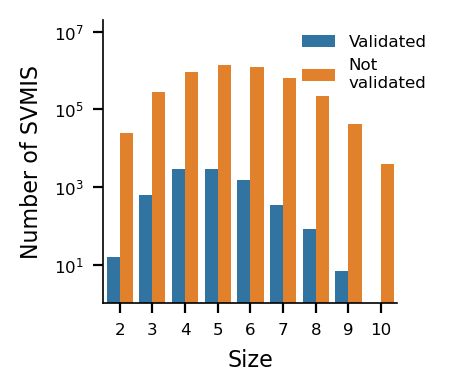

In [10]:
# plot number of validated and non-validated sets
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3, h_inc))

# plot counts of svmis by size
sns.countplot(data=svmis_df, x="size", hue="fdr", hue_order=[True, False], ax=ax)

ax.set_yscale("log")
ax.set_ylim(1, 2e7)
ax.set_yticks([1e1, 1e3, 1e5, 1e7])

# remove minor thicks from y axis
ax.yaxis.set_minor_locator(plt.NullLocator())

ax.set_ylabel("Number of SVMIS")
ax.set_xlabel("Size")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Validated", "Not\nvalidated"], loc="upper right", bbox_to_anchor=(1.15, 1.), title=None, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')

### Frequency-rank analysis of ingredients and validated sets across recipes

In [12]:
# get frequency of all ingredients in the hypergraph
freq_ingredients = np.array(sorted(list(H_cut.degree_sequence().values()), reverse=True))

In [13]:
# get frequency of all validated sets
all_recipes = set(H_cut.get_edges())

freq_svmis_df = []
for _, row in tqdm(svmis_df.query("fdr == True").iterrows(), total=svmis_df.fdr.sum()):
    
    # the the validated set
    group = row["group"]
    group = set(group)
    group_ingredients = " - ".join([H_cut.get_node_metadata(n)["name"] for n in group])

    # get all recipes that contain this group and the set of cuisines those recipes belong to
    recipes_ = {r for r in all_recipes if set(r).issuperset(group)}
    cuisines_ = [f for r in recipes_ for f in H_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

    line = {
        "group": group,
        "group_ingredients": group_ingredients,
        "size": len(group),
        "n_recipes": len(recipes_),
        "cuisine_list": cuisines_
    }

    freq_svmis_df.append(line)

freq_svmis_df = pd.DataFrame(freq_svmis_df)
freq_svmis_df.head()

  0%|          | 0/8297 [00:00<?, ?it/s]

,group,group_ingredients,size,n_recipes,cuisine_list
0,"{1, 39, 40, 15, 47, 17, 18, 58, 31}",chili pepper - rice - ghee - cardamom - ginger...,9,2,"[indian, indian]"
1,"{2, 7, 10, 11, 44, 13, 23, 56, 26}",sunflower - mustard oil - asafoetida - cayenne...,9,2,"[indian, indian]"
2,"{4, 8, 40, 10, 11, 15, 17, 18, 51}",cumin - nigella seed - ghee - asafoetida - cay...,9,2,"[indian, indian]"
3,"{1, 2, 3, 7, 10, 12, 13, 23, 26}",chili pepper - sunflower - buttermilk - mustar...,9,2,"[indian, indian]"
4,"{1, 2, 3, 4, 40, 10, 45, 26, 29}",chili pepper - sunflower - buttermilk - cumin ...,9,2,"[indian, indian]"


##### Frequency of validated sets in randomized model

In [11]:
def randomize_bip_conf_model(recipes_df, seed=None):
    """ Ensuring node labels are the same
    """
    import networkx as nx

    # make the graph
    G = nx.Graph()

    ing_nodes = recipes_df["ingredient"].unique().tolist()
    rec_nodes = recipes_df["id"].unique().tolist()

    G.add_nodes_from(ing_nodes, bipartite=0)
    G.add_nodes_from(rec_nodes, bipartite=1)

    G.add_edges_from(recipes_df[["id", "ingredient"]].values.tolist())

    # get degree sequences of ingredients and recipes
    ing_deg_seq = [G.degree(ing) for ing in ing_nodes]
    rec_deg_seq = [G.degree(rec) for rec in rec_nodes]


    # build configuration model with explicit node lists
    G_tmp = nx.bipartite.configuration_model(rec_deg_seq, ing_deg_seq, create_using=nx.Graph(), seed=seed)

    # relabel nodes to maintain the original labels
    left_map  = dict(zip(range(len(rec_nodes)), rec_nodes))
    right_map = dict(zip(range(len(rec_nodes), len(rec_nodes)+len(ing_nodes)), ing_nodes))

    mapping = {**left_map, **right_map}
    G_tmp = nx.relabel_nodes(G_tmp, mapping)

    # return to dataframe
    recipes_rand_df = []
    for rec_id in rec_nodes:
        for ing in G_tmp.neighbors(rec_id):
            recipes_rand_df.append([rec_id, ing])

    recipes_rand_df = pd.DataFrame(recipes_rand_df, columns=["id", "ingredient"])
    recipes_rand_df = recipes_rand_df.merge(recipes_df[["id", "cuisine"]].drop_duplicates(), on="id", how="left")

    return recipes_rand_df


def load_recipies_shuff(seed=None):

    if seed is None:
        seed = 42

    # small number of recipes in these cuisines
    CUISINES_EXCLUDE = ["misc_central_american", "misc_dutch", "misc_belgian"]

    recipes_df = pd.read_csv("../data/recipies/edgelist.csv", sep=";")
    recipes_df = recipes_df[~recipes_df.cuisine.isin(CUISINES_EXCLUDE)]

    # get ingredients
    all_ingredients_df = recipes_df[["ingredient", "category"]].drop_duplicates().reset_index(drop=True)

    # get all cuisines
    all_cuisines_list = recipes_df["cuisine"].unique().tolist()

    # shuffle in like a bipartite configuration model for each cuisine
    recipes_shuff_df = []
    for iii, cuisine in enumerate(all_cuisines_list):
        df_ = recipes_df[recipes_df["cuisine"] == cuisine]
        df_shuff = randomize_bip_conf_model(df_, seed=seed + iii * 123)
        recipes_shuff_df.append(df_shuff)

    recipes_df = pd.concat(recipes_shuff_df).reset_index(drop=True)
        
    node2id = {}
    H = hgx.Hypergraph()
    for recipe_id, ingredients_df in recipes_df.groupby("id"):

        if len(ingredients_df) < 2:
            continue

        cuisine = ingredients_df["cuisine"].values[0]

        edge = set()
        for _, row in ingredients_df.iterrows():
            ingredient = row["ingredient"]

            if ingredient not in node2id:
                node_id = len(node2id)
                node2id[ingredient] = node_id

                H.add_node(node_id, metadata={"name": ingredient})
            else:
                node_id = node2id[ingredient]

            edge.add(node_id)

        edge = tuple(sorted(edge))

        if not H.check_edge(edge):
            edge_meta = {"recipe_id": str(recipe_id), "cuisine": cuisine}
            H.add_edge(edge, metadata=edge_meta)
        else:
            edge_meta = H.get_edge_metadata(edge)
            edge_meta["recipe_id"] += f" - {recipe_id}"
            edge_meta["cuisine"] += f" - {cuisine}" if cuisine not in edge_meta["cuisine"] else ""
            H.set_edge_metadata(edge, edge_meta)
            
    # add node id to all_ingredients_df
    all_ingredients_df["node_id"] = all_ingredients_df["ingredient"].map(node2id)

    return H, all_ingredients_df, all_cuisines_list


def get_freq_rank_plot_shuff(seed=None):

    H_shuff, _, _ = load_recipies_shuff(seed=seed)

    # remove hyperedges of size > 10
    H_shuff_cut = H_shuff.copy()

    for size in range(11, H_shuff_cut.max_size() + 1):
        for edge in H_shuff_cut.get_edges(size=size):
            H_shuff_cut.remove_edge(edge)

    # remove isolated nodes
    for node in H_shuff_cut.isolated_nodes():
        H_shuff_cut.remove_node(node)

    # run SVMIS extraction
    svmis_shuff_df = get_svmis(H_shuff_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
    svmis_shuff_df = pd.concat(svmis_shuff_df).reset_index(drop=True)

    # count support of validated sets in recipes
    all_recipes_shuff = set(H_shuff_cut.get_edges())

    freq_svmis_shuff_df = []
    for _, row in tqdm(svmis_shuff_df.query("fdr == True").iterrows(), total=svmis_shuff_df.fdr.sum(), leave=False):
        
        # the the validated set
        group = row["group"]
        group = set(group)

        # get all recipes that contain this group and the set of cuisines those recipes belong to
        recipes_ = {r for r in all_recipes_shuff if set(r).issuperset(group)}
        cuisines_ = [f for r in recipes_ for f in H_shuff_cut.get_edge_metadata(r)["cuisine"].split(" - ")]

        line = {
            "group": group,
            "size": len(group),
            "n_recipes": len(recipes_),
            "cuisine_list": cuisines_
        }

        freq_svmis_shuff_df.append(line)

    freq_svmis_shuff_df = pd.DataFrame(freq_svmis_shuff_df)

    return freq_svmis_shuff_df

In [15]:
import pickle

NITERS = 50
RNG = np.random.RandomState(42)
file_null_freqs = "../results/recipes/svmis_counts_nulls.pkl"

if not os.path.exists(file_null_freqs):
    print("Computing null frequencies..")

    freq_svmis_nulls_list = []
    for _ in tqdm(range(NITERS), total=NITERS):
        seed = RNG.randint(0, 10000)
        freq_svmis_shuff_df = get_freq_rank_plot_shuff(seed=seed)
        freq_svmis_nulls_list.append(freq_svmis_shuff_df.n_recipes.sort_values(ascending=False).values)

    import pickle
    with open(file_null_freqs, "wb") as ww:
        pickle.dump(freq_svmis_nulls_list, ww)

else:
    print("Load precomputed..")
    with open(file_null_freqs, "rb") as rr:
        freq_svmis_nulls_list = pickle.load(rr)

Load precomputed..


##### Plot the distributions

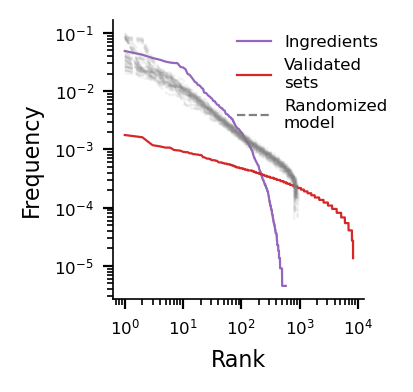

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(w_inc_fullpage/3, h_inc))

# plot freq-rank of ingredients
ax.plot(np.arange(1, len(freq_ingredients) + 1), freq_ingredients/freq_ingredients.sum(), linestyle='-', label="Ingredients", color='C4')

# plot freq-rank of validated sets
freq_validated_sets = freq_svmis_df.sort_values("n_recipes", ascending=False)["n_recipes"].values
ax.plot(np.arange(1, len(freq_validated_sets) + 1), freq_validated_sets/freq_validated_sets.sum(), linestyle='-', label="Validated sets", color='C3')

# plot envelope of null model
for freq_null in freq_svmis_nulls_list:
    ax.plot(np.arange(1, len(freq_null) + 1), freq_null/freq_null.sum(), color='grey', alpha=0.1, linestyle='--')

ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")

# make legend manyally
handles = [
    plt.Line2D([0], [0], color='C4', linestyle='-', label='Ingredients'),
    plt.Line2D([0], [0], color='C3', linestyle='-', label='Validated\nsets'),
    plt.Line2D([0], [0], color='grey', linestyle='--', label='Randomized\nmodel')
]
ax.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.15, 1.), frameon=False)


ax.set_xscale("log")
ax.set_yscale("log")

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_aspect('equal', adjustable='box')
fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "Recipes_SVMIS_FreqRank.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')